# booking scraping

In [1]:
from seleniumwire import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import date, timedelta
import datetime as dt
from urllib.parse import urlsplit, urlunsplit
import re

### properties extractor

In [2]:
def safe_wrapper(func):
    def inner(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except Exception as e:
            return None
    return inner


@safe_wrapper
def get_name(card):
    return card.find_element(By.CSS_SELECTOR, 'div[data-testid="title"]').text
@safe_wrapper
def get_reviews(card):
    return card.find_element(By.CSS_SELECTOR, '[data-testid="review-score"]').text.split('\n')
@safe_wrapper
def get_price(card):
    return card.find_element(By.CSS_SELECTOR, '[data-testid="price-and-discounted-price"]').text
@safe_wrapper
def get_location(card):
    return card.find_element(By.CSS_SELECTOR, '[data-testid="address"]').text
@safe_wrapper
def place_from_center(card):
    return card.find_element(By.CSS_SELECTOR, '[data-testid="distance"]').text
@safe_wrapper
def location_score(card):
    return card.find_element(By.CSS_SELECTOR, '[data-testid="secondary-review-score-link"]').text
@safe_wrapper
def is_sustainable(card):
    return card.find_element(By.XPATH, './/*[@class="a51f4b5adb"]').text
@safe_wrapper
def recommended_unit(card):
    return card.find_element(By.CSS_SELECTOR, '[data-testid="recommended-units"]').text
@safe_wrapper
def rating_stars(card):
    text = card.find_element(By.XPATH, './/*[@class="e4755bbd60"]').get_attribute('aria-label')
    return text[0]
@safe_wrapper
def free_cancelation(card):
    return card.find_element(By.CSS_SELECTOR, '[class="d506630cf3"]').text.lower()
@safe_wrapper
def is_breakfast_included(card):
    return card.find_element(By.XPATH, './/*[@class="e05969d63d"]').text
@safe_wrapper
def review_summery(card):
    return card.find_element(By.XPATH, './/*[@class="b5cd09854e f0d4d6a2f5 e46e88563a"]').text
@safe_wrapper
def room_name_type(card):
    return card.find_element(By.XPATH, './/*[@class="df597226dd"]').text
@safe_wrapper
def bed_room_type(card):
    return card.find_element(By.XPATH, './/*[@class="cb5b4b68a4"]').text
@safe_wrapper
def subway_access(card):
    sub = card.find_element(By.XPATH,'.//*[@data-testid="location"]')
    return sub.find_element(By.XPATH, './/*[@<span class="cb5ebe3ffb"><span aria-expanded="false">]').text
@safe_wrapper
def get_url(card):
    return card.find_element(By.CSS_SELECTOR, 'a[data-testid="title-link"]').get_attribute('href')
@safe_wrapper
def is_preferred_badge(card):
    badge =  card.find_element(By.XPATH,'.//*[@data-testid="preferred-badge"]')
    if badge:
        return True
    else:
        return False
@safe_wrapper
def is_promoted(card):
    return card.find_element(By.XPATH,'.//*[@class="e2f34d59b1"]').text
@safe_wrapper
def is_parking(card):
    return driver.find_element(By.XPATH,'.//*[@class="db312485ba"]').text


In [3]:
def extract_properties(los,ttt,check_in,check_out):
    property_cards = driver.find_elements(By.XPATH, './/*[@data-testid="property-card"]')
    for card in property_cards:
        new_property = {}
        new_property['element'] = card.id
        new_property['url'] = get_url(card)
        new_property['check_in'] = check_in
        new_property['check_out'] = check_out
        new_property['length_of_stay'] = los
        new_property['time_to_travel'] = ttt
        new_property['name'] = get_name(card)
        new_property['review_score'], _, new_property['review_count'] = get_reviews(card) or (None, None, None)
        new_property['review_summery'] = review_summery(card)
        new_property['price'] = get_price(card)
        new_property['address'] = get_location(card)
        new_property['distance_from_center'] = place_from_center(card)
        new_property['location_score'] = location_score(card)
        new_property['is_sustainable'] = is_sustainable(card)
        new_property['recommended_unit'] = recommended_unit(card)
        new_property['rating_stars'] = rating_stars(card)
        new_property['free_cancelation'] = free_cancelation(card)
        new_property['is_breakfast_included'] = is_breakfast_included(card)
        new_property['room_name_type'] = room_name_type(card)
        new_property['bed_room_type'] = bed_room_type(card)
        new_property['preferred_badge'] = is_preferred_badge(card)
        new_property['subway_access'] = subway_access(card)
        new_property['is_promoted'] = is_promoted(card)

        properties.append(new_property)

### url maker

In [4]:
tmp_date = dt.date.today()
dates = []
for i in range(1,31):
    for j in range(1,6):
        new_date = {}
        new_date['LOS'] = j
        new_date['TTT'] = i
        new_date['chekin'] = tmp_date
        new_date['checkout'] = tmp_date + timedelta(days=j)
        city = 'New York'
        checking_year = new_date['chekin'].year
        checking_month = new_date['chekin'].month
        checking_monthday = new_date['chekin'].day
        checkout_year = new_date['checkout'].year
        checkout_month = new_date['checkout'].month
        checkout_monthday = new_date['checkout'].day
        numOfAdults = 2
        numOfChild = 0
        numOfRooms = 1
        new_date['url'] = f'https://www.booking.com/searchresults.html?ss={city}&checkin_year={checking_year}&checkin_month={checking_month}&checkin_monthday={checking_monthday}&checkout_year={checkout_year}&checkout_month={checkout_month}&checkout_monthday={checkout_monthday}&group_adults={numOfAdults}&group_children={numOfChild}&no_rooms={numOfRooms}'
        dates.append(new_date)
    tmp_date = tmp_date + timedelta(days=1)

In [5]:
print(len(dates))
print(tmp_date)

150
2023-04-25


### scraper

In [6]:
properties = []
i=0
for row in dates:
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    url = row['url']
    driver.get(url)
    ttt = row['TTT']
    los = row['LOS']
    check_in = row['chekin']
    check_out = row['checkout']
    driver.maximize_window()
    total_pages = int(driver.find_element(By.CSS_SELECTOR, 'div[data-testid="pagination"]  li:last-child').text)
    print(f"Total pages: {total_pages}")
    i = i + 1
    print(f"iter: {i}")

    for current_page in range(1,7):
        #del driver.requests
        time.sleep(5)
        extract_properties(los = los, ttt = ttt, check_in = check_in, check_out =check_out)
        next_page_btn = driver.find_element(By.XPATH, '//button[contains(@aria-label, "Next page")]')
        next_page_btn.click()
        time.sleep(5)
        driver.wait_for_request("/dml/graphql", timeout=5)

    time.sleep(1)
    driver.close()


booking_df = pd.DataFrame(properties)
booking_df.to_csv(f'booking_properties_2_{tmp_date}.csv', index=False)

Total pages: 18
iter: 1
Total pages: 18
iter: 2
Total pages: 17
iter: 3
Total pages: 17
iter: 4
Total pages: 16
iter: 5
Total pages: 17
iter: 6
Total pages: 17
iter: 7
Total pages: 18
iter: 8
Total pages: 18
iter: 9
Total pages: 16
iter: 10
Total pages: 17
iter: 11
Total pages: 17
iter: 12
Total pages: 17
iter: 13
Total pages: 17
iter: 14
Total pages: 15
iter: 15
Total pages: 17
iter: 16
Total pages: 17
iter: 17
Total pages: 17
iter: 18
Total pages: 17
iter: 19
Total pages: 16
iter: 20
Total pages: 19
iter: 21
Total pages: 17
iter: 22
Total pages: 17
iter: 23
Total pages: 18
iter: 24
Total pages: 18
iter: 25
Total pages: 18
iter: 26
Total pages: 17
iter: 27
Total pages: 17
iter: 28
Total pages: 18
iter: 29
Total pages: 18
iter: 30
Total pages: 14
iter: 31
Total pages: 16
iter: 32
Total pages: 18
iter: 33
Total pages: 17
iter: 34
Total pages: 18
iter: 35
Total pages: 19
iter: 36
Total pages: 17
iter: 37
Total pages: 18
iter: 38
Total pages: 18
iter: 39
Total pages: 18
iter: 40
Total pag

### phase 2 - data cleaning

In [10]:
booking_2_df = pd.read_csv("booking_properties_2_4.3.23.csv")
booking_2_df['sample_id'] = 1
booking_3_df = pd.read_csv("booking_properties_2_2023-04-24.csv")
booking_3_df['sample_id'] = 2
booking_4_df = pd.read_csv("booking_properties_2_2023-04-25.csv")
booking_4_df['sample_id'] = 3

In [11]:
booking_2_df = booking_2_df.append(booking_3_df, ignore_index=True)
booking_2_df = booking_2_df.append(booking_4_df, ignore_index=True)

/var/folders/cr/sz5qnpp96w183bm2h622d9yc0000gn/T/ipykernel_44850/3389451692.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  booking_2_df = booking_2_df.append(booking_3_df, ignore_index=True)
/var/folders/cr/sz5qnpp96w183bm2h622d9yc0000gn/T/ipykernel_44850/3389451692.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  booking_2_df = booking_2_df.append(booking_4_df, ignore_index=True)


In [12]:
booking_2_df

element  \
0      b600fc1e-174a-444a-bf45-4dbd0a62ef78   
1      bfb95abd-6fb8-40a8-a4fa-538ef48764de   
2      cc9a1804-0c4c-4dd0-9432-a8ccabe31494   
3      77092025-974b-409e-9d95-16941c2104a2   
4      c9e81d40-0999-45df-bdb5-1ea93b3b55c4   
...                                     ...   
72205  042b34ae-44d1-4769-b02a-832b104c591c   
72206  e74f5613-c11e-44a9-ade4-bf8db8252e50   
72207  795a6687-dc8a-4956-9157-806af1fe3676   
72208  94d689c8-7f97-4988-a457-3e0d85f29ab1   
72209  29af6d66-be41-46ae-80ca-b4d6b18109a0   

                                                     url    check_in  \
0      https://www.booking.com/hotel/us/holiday-inn-l...  2023-03-05   
1      https://www.booking.com/hotel/us/margaritavill...  2023-03-05   
2      https://www.booking.com/hotel/us/the-draper-as...  2023-03-05   
3      https://www.booking.com/hotel/us/nhcollection-...  2023-03-05   
4      https://www.booking.com/hotel/us/omni-bershire...  2023-03-05   
...                                                  ...         ...   
72205  https://www.booking.com/hotel/us/fairfield-inn...  2023-04-24   
72206  https://www.booking.com/hotel/us/park-lane-new...  2023-04-24   
72207  https://www.booking.com/hotel/us/arlo-nomad.ht...  2023-04-24   
72208  https://www.booking.com/hotel/us/archer-new-yo...  2023-04-24   
72209  https://www.booking.com/hotel/us/the-william-e...  2023-04-24   

        check_out  length_of_stay  time_to_travel  \
0      2023-03-06               1               1   
1      2023-03-06               1               1   
2      2023-03-06               1               1   
3      2023-03-06               1               1   
4      2023-03-06               1               1   
...           ...             ...             ...   
72205  2023-04-29               5              30   
72206  2023-04-29               5              30   
72207  2023-04-29               5              30   
72208  2023-04-29               5              30   
72209  2023-04-29               5              30   

                                                    name  review_score  \
0              Holiday Inn Lower East Side, an IHG Hotel           7.9   
1                     Margaritaville Resort Times Square           8.8   
2      The Draper New York, Tapestry Collection by Hi...           8.4   
3                  NH Collection New York Madison Avenue           8.2   
4                                   Omni Berkshire Place           8.7   
...                                                  ...           ...   
72205  Fairfield Inn & Suites by Marriott New York Ma...           8.0   
72206                                 Park Lane New York           8.4   
72207                                         Arlo NoMad           8.1   
72208                              Archer Hotel New York           8.7   
72209                                 Sonder The William           7.9   

        review_count review_summery  ...  \
0        695 reviews           Good  ...   
1      1,367 reviews      Excellent  ...   
2      1,009 reviews      Very Good  ...   
3      1,168 reviews      Very Good  ...   
4        519 reviews      Excellent  ...   
...              ...            ...  ...   
72205  5,226 reviews      Very Good  ...   
72206  1,689 reviews      Very Good  ...   
72207  2,433 reviews      Very Good  ...   
72208    718 reviews      Excellent  ...   
72209    400 reviews           Good  ...   

                                        recommended_unit rating_stars  \
0      King Leisure Room\n1 king bed\nOnly 1 room lef...          4.0   
1      Deluxe Queen Room\n1 queen bed\nOnly 4 rooms l...          4.0   
2          Double Room with Two Double Beds\n2 full beds          3.0   
3      Superior Double or Twin Room\nBeds: 1 double o...          4.0   
4                           Deluxe King Room\n1 king bed          4.0   
...                                                  ...          ...   
72205  2 Queen Beds\n2 queen beds\nBreak

In [13]:
booking_2_df.length_of_stay.unique()

array([1, 2, 3, 4, 5])

In [14]:
counter = 1
booking_2_df["place_in_page"] = 0
los = 1
i = 0  # initialize i to 0 instead of 1
for row in booking_2_df["length_of_stay"]:
    if row == los:
        booking_2_df.loc[i,"place_in_page"] = counter
        counter = counter + 1
    else:
        los = los + 1
        counter = 1
        if los == 6:
            los = 1
        booking_2_df.loc[i,"place_in_page"] = counter  # assign counter to the current row
        counter = counter + 1
    i = i + 1  # increment i after each iteration

In [15]:
mapping = {'NaN':0,'nan':0,'Review score':0,'Good': 1, 'Very Good': 2, 'Excellent': 3, 'Wonderful': 4,'Exceptional':5}
booking_2_df['review_summery'] = booking_2_df['review_summery'].map(mapping)

In [16]:
booking_2_df['is_breakfast_included'] = booking_2_df['is_breakfast_included'].notnull().astype(int)

In [17]:
booking_2_df['price'] = booking_2_df['price'].apply(lambda x: int(re.sub('[^0-9]','', str(x))) if pd.notnull(x) else x)

In [18]:
booking_2_df['review_count'] = booking_2_df['review_count'].apply(lambda x: int(re.sub('[^0-9]','', str(x))) if pd.notnull(x) else x)

In [19]:
booking_2_df['location_score'] = booking_2_df['location_score'].str.extract('(\d+\.\d+)').astype(float)

In [20]:
booking_2_df['preferred_badge'] = booking_2_df['preferred_badge'].notnull().astype(int)

In [21]:
extracted_df = booking_2_df['distance_from_center'].str.extractall(r'(\d+(?:\.\d+)?)')[0]
extracted_df = extracted_df.reset_index(level=1, drop=True)
extracted_df = extracted_df.astype(float)
extracted_df = extracted_df.apply(lambda x: x/1000 if x >= 100 else x)
extracted_df = extracted_df.rename("distance_from_center_by_km")
booking_2_df = booking_2_df.drop(columns=["distance_from_center"])
booking_2_df = pd.concat([booking_2_df, extracted_df], axis=1)

In [22]:
booking_2_df['free_cancelation'] = booking_2_df['free_cancelation'].notnull().astype(int)

In [23]:
booking_2_df['is_sustainable'] = booking_2_df['is_sustainable'].notnull().astype(int)

In [24]:
booking_2_df['is_promoted'] = booking_2_df['is_promoted'].notnull().astype(int)

In [25]:
booking_2_df['check_in'] = pd.to_datetime(booking_2_df['check_in'])

In [26]:
booking_2_df['check_out'] = pd.to_datetime(booking_2_df['check_out'])

In [27]:
booking_2_df['price'] = round(booking_2_df['price']*0.29,2)

In [28]:
booking_2_df = booking_2_df.drop(columns = ['subway_access'])

In [29]:
booking_2_df['bed_room_type'].str.lower().unique()

array(['1 king bed', '1 queen bed', '2 full beds',
       'beds: 1 double or 2 twins', nan, '2 twin beds', '1 full bed',
       'entire studio • 1 bathroom • 19m²\n1 king bed',
       'private suite\n1 king bed',
       'entire studio • 1 bathroom • 35m²\n1 full bed',
       'entire studio • 1 bathroom • 25m²\n1 king bed',
       'entire studio • 1 bathroom • 28m²\n2 beds (1 king, 1 sofa bed)',
       '1 bunk bed', '2 queen beds',
       'private suite • 1 bedroom • 1 living room • 1 bathroom • 30m²\n1 king bed',
       'private suite\n2 beds (1 king, 1 sofa bed)',
       'entire studio • 1 bathroom • 18m²\n1 king bed',
       'private suite\n2 beds (1 sofa bed, 1 queen)',
       'entire studio • 1 bathroom • 29m²\n1 queen bed',
       'entire studio • 1 bathroom • 35m²\n2 beds (1 king, 1 sofa bed)',
       'multiple bed types', '2 beds (1 king, 1 sofa bed)',
       '2 beds (1 sofa bed, 1 queen)',
       'entire studio • 1 bathroom • 325m²\n1 king bed',
       'entire studio • 1 bathro

In [30]:
booking_2_df['bed_room_type'].fillna(0, inplace=True)

In [31]:
def bed_type_to_score(bed):
    if bed == 0:
        return 0
    elif 'suite' in bed:
        return 8
    elif 'king' in bed:
        return 7
    elif 'queen' in bed:
        return 6
    elif 'twin' in bed:
        return 5
    elif 'full' in bed:
        return 4
    elif'sofa' in bed:
        return 3
    elif 'futon' in bed:
        return 2
    else:
        return 1

In [32]:
booking_2_df['bed_room_type'] = booking_2_df['bed_room_type'].apply(lambda x: bed_type_to_score(x))

In [33]:
booking_2_df['room_name_type'].str.lower().unique()

array(['king leisure room', 'deluxe queen room',
       'double room with two double beds', 'superior double or twin room',
       'deluxe king room', 'archer king guest room',
       'classic double room', 'bunk pod', 'king room', 'deluxe king',
       'superior queen room', 'room with murphy bed',
       'social city view king', 'double room', 'queen room',
       'classic room', 'standard room with two double beds',
       'king or queen room with city view', 'large double room',
       'superior courtyard king', '1 king bed', 'queen garden room',
       'executive queen room', 'leisure king room - non-smoking',
       'classic 1 queen bed', 'king room - non-smoking',
       'standard king room', 'studio king room',
       'newly renovated standard queen room', 'small queen room',
       'king studio with kitchenette', 'soho king room',
       'standard queen room',
       'king room with roll-in shower - disability access',
       'classic king room - low floor', 'the innside room 

In [34]:
booking_2_df['room_name_type'].fillna(0,inplace=True)

In [35]:
def room_name_type_to_score(room):
    if room == 0:
        return 0
    elif 'suite' in room:
        return 7
    elif 'king' in room:
        return 6
    elif 'queen' in room:
        return 5
    elif 'double' in room:
        return 4
    elif 'twin' in room:
        return 4
    elif 'full' in room:
        return 3
    elif 'studio' in room:
        return 3
    elif 'classic' in room:
        return 3
    elif 'standard' in room:
        return 3
    elif'sofa' in room:
        return 2
    elif 'petite' in room:
        return 2
    elif 'futon' in room:
        return 1
    elif 'pod' in room:
        return 1
    else:
        return 0

In [36]:
booking_2_df['room_name_type'] = booking_2_df['room_name_type'].apply(lambda x: room_name_type_to_score(x))

In [37]:
booking_2_df['price_per_night'] = round(booking_2_df['price']/booking_2_df['length_of_stay'], 2)

In [38]:
booking_2_df.fillna(0,inplace=True)

In [39]:
booking_2_df.head()

element  \
0  b600fc1e-174a-444a-bf45-4dbd0a62ef78   
1  bfb95abd-6fb8-40a8-a4fa-538ef48764de   
2  cc9a1804-0c4c-4dd0-9432-a8ccabe31494   
3  77092025-974b-409e-9d95-16941c2104a2   
4  c9e81d40-0999-45df-bdb5-1ea93b3b55c4   

                                                 url   check_in  check_out  \
0  https://www.booking.com/hotel/us/holiday-inn-l... 2023-03-05 2023-03-06   
1  https://www.booking.com/hotel/us/margaritavill... 2023-03-05 2023-03-06   
2  https://www.booking.com/hotel/us/the-draper-as... 2023-03-05 2023-03-06   
3  https://www.booking.com/hotel/us/nhcollection-... 2023-03-05 2023-03-06   
4  https://www.booking.com/hotel/us/omni-bershire... 2023-03-05 2023-03-06   

   length_of_stay  time_to_travel  \
0               1               1   
1               1               1   
2               1               1   
3               1               1   
4               1               1   

                                                name  review_score  \
0          Holiday Inn Lower East Side, an IHG Hotel           7.9   
1                 Margaritaville Resort Times Square           8.8   
2  The Draper New York, Tapestry Collection by Hi...           8.4   
3              NH Collection New York Madison Avenue           8.2   
4                               Omni Berkshire Place           8.7   

   review_count  review_summery  ...  free_cancelation is_breakfast_included  \
0         695.0             1.0  ...                 0                     0   
1        1367.0             3.0  ...                 0                     0   
2        1009.0             2.0  ...                 0                     0   
3        1168.0             2.0  ...                 0                     0   
4         519.0             3.0  ...                 0                     0   

   room_name_type  bed_room_type preferred_badge  is_promoted  sample_id  \
0               0              7               0            1          1   
1               0              6               1            0          1   
2               0              4               1            0          1   
3               0              5               1            1          1   
4               0              7               1            0          1   

   place_in_page  distance_from_center_by_km  price_per_night  
0              1                         5.6           111.07  
1              2                         1.5           168.20  
2              3                         1.9           169.07  
3              4                         2.0           228.81  
4              5                         1.1           279.56  

[5 rows x 26 columns]

In [40]:
booking_df = booking_2_df

In [41]:
booking_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72210 entries, 0 to 72209
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   element                     72210 non-null  object        
 1   url                         72210 non-null  object        
 2   check_in                    72210 non-null  datetime64[ns]
 3   check_out                   72210 non-null  datetime64[ns]
 4   length_of_stay              72210 non-null  int64         
 5   time_to_travel              72210 non-null  int64         
 6   name                        72210 non-null  object        
 7   review_score                72210 non-null  float64       
 8   review_count                72210 non-null  float64       
 9   review_summery              72210 non-null  float64       
 10  price                       72210 non-null  float64       
 11  address                     72210 non-null  object    

In [42]:
booking_2_df.to_csv('booking_properties_cleaned.csv', index=False)

### phase 2 - data exploration

In [43]:
booking_df.describe()

length_of_stay  time_to_travel  review_score  review_count  \
count    72210.000000    72210.000000  72210.000000  72210.000000   
mean         3.002493       15.513918      7.940704   2095.433583   
std          1.415102        8.651777      0.844730   2396.447884   
min          1.000000        1.000000      0.000000      0.000000   
25%          2.000000        8.000000      7.600000    680.000000   
50%          3.000000       15.000000      8.100000   1284.000000   
75%          4.000000       23.000000      8.400000   2546.000000   
max          5.000000       30.000000     10.000000  15273.000000   

       review_summery         price  location_score  is_sustainable  \
count    72210.000000  7.221000e+04    72210.000000    72210.000000   
mean         1.680100  1.213587e+05        4.186946        0.607312   
std          0.817861  2.259970e+06        4.693860        0.488352   
min          0.000000  0.000000e+00        0.000000        0.000000   
25%          1.000000  4.843000e+02        0.000000        0.000000   
50%          2.000000  8.582550e+02        0.000000        1.000000   
75%          2.000000  1.281220e+03        9.400000        1.000000   
max          5.000000  3.166542e+08        9.900000        1.000000   

       rating_stars  free_cancelation  is_breakfast_included  room_name_type  \
count  72210.000000      72210.000000           72210.000000    72210.000000   
mean       3.833569          0.587883               0.211744        0.266805   
std        0.733328          0.492219               0.408547        1.236797   
min        0.000000          0.000000               0.000000        0.000000   
25%        4.000000          0.000000               0.000000        0.000000   
50%        4.000000          1.000000               0.000000        0.000000   
75%        4.000000          1.000000               0.000000        0.000000   
max        5.000000          1.000000               1.000000        6.000000   

       bed_room_type  preferred_badge   is_promoted     sample_id  \
count   72210.000000     72210.000000  72210.000000  72210.000000   
mean        6.168772         0.914652      0.203587      1.934774   
std         1.407737         0.279401      0.402668      0.827142   
min         0.000000         0.000000      0.000000      1.000000   
25%         6.000000         1.000000      0.000000      1.000000   
50%         7.000000         1.000000      0.000000      2.000000   
75%         7.000000         1.000000      0.000000      3.000000   
max         8.000000         1.000000      1.000000      3.000000   

       place_in_page  distance_from_center_by_km  price_per_night  
count   72210.000000                72210.000000     7.221000e+04  
mean       82.068342                    2.637360     3.448190e+04  
std        48.880524                    2.047084     5.035671e+05  
min         1.000000                    0.000000     0.000000e+00  
25%        41.000000                    1.300000     2.394050e+02  
50%        81.000000                    1.900000     2.958600e+02  
75%       121.000000                    3.000000     3.600400e+02  
max       210.000000                    9.800000     6.333083e+07

In [44]:
booking_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72210 entries, 0 to 72209
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   element                     72210 non-null  object        
 1   url                         72210 non-null  object        
 2   check_in                    72210 non-null  datetime64[ns]
 3   check_out                   72210 non-null  datetime64[ns]
 4   length_of_stay              72210 non-null  int64         
 5   time_to_travel              72210 non-null  int64         
 6   name                        72210 non-null  object        
 7   review_score                72210 non-null  float64       
 8   review_count                72210 non-null  float64       
 9   review_summery              72210 non-null  float64       
 10  price                       72210 non-null  float64       
 11  address                     72210 non-null  object    

In [45]:
plt.figure(figsize=(20, 10))
sns.set_style('whitegrid')

ax = sns.countplot(x='review_score', data=booking_df, order=booking_df['review_score'].value_counts().sort_index(ascending=True).index,palette="rocket")

# rotate x-axis labels
plt.xticks(rotation=45)

# add labels and title to the plot
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.title('Distribution of Review Scores')

# add count values to the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.show()

In [46]:
plt.figure(figsize=(20, 10))
sns.barplot(x = 'review_score', y = 'review_count', data = booking_df)
plt.title('Distribution of Review Score with count',fontsize=20)
plt.xlabel('Review Score', fontsize = 15)
plt.ylabel('reviews count',fontsize = 15)

plt.show()

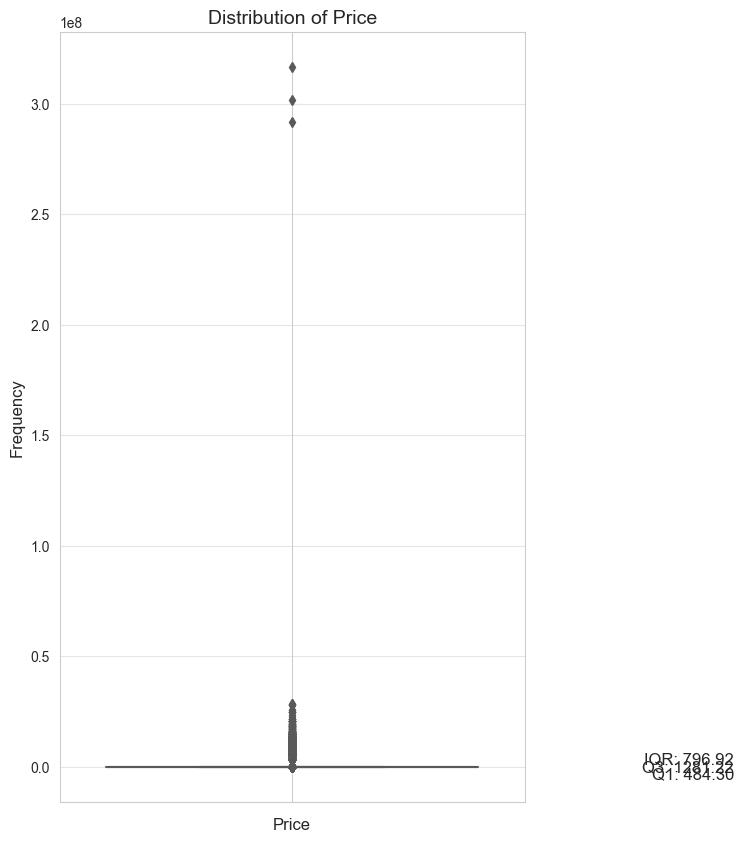

In [47]:
plt.figure(figsize=(6, 10))
sns.set_style('whitegrid')

sns.boxplot(y='price', data=booking_df, palette='Set2')
plt.grid(True)

plt.title('Distribution of Price', fontsize=14)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.grid(axis='y', alpha=0.5)

q1, q3 = booking_df['price'].quantile([0.25, 0.75])
iqr = q3 - q1
plt.text(0.95, q1, f'Q1: {q1:.2f}', fontsize=12, va='top', ha='right')
plt.text(0.95, q3, f'Q3: {q3:.2f}', fontsize=12, va='center', ha='right')
plt.text(0.95, q1 + 0.5*iqr, f'IQR: {iqr:.2f}', fontsize=12, va='bottom', ha='right')

plt.show()

In [48]:
plt.figure(figsize=(6, 10))
sns.set_style('whitegrid')

sns.boxplot(y='price_per_night', data=booking_df, palette='Set2')
plt.grid(True)

plt.title('Distribution of Price per night', fontsize=14)
plt.xlabel('Price per night', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.grid(axis='y', alpha=0.5)

q1, q3 = booking_df['price_per_night'].quantile([0.25, 0.75])
iqr = q3 - q1
plt.text(0.95, q1, f'Q1: {q1:.2f}', fontsize=12, va='top', ha='right')
plt.text(0.95, q3, f'Q3: {q3:.2f}', fontsize=12, va='center', ha='right')
plt.text(0.95, q1 + 0.5*iqr, f'IQR: {iqr:.2f}', fontsize=12, va='bottom', ha='right')

plt.show()

In [49]:
#tukey methods for cleaning data
prices = booking_df['price']
q1 = prices.quantile(0.25)
q3 = prices.quantile(0.75)
iqr = q3 - q1
filt_price = prices.apply(lambda x:x>q1-1.5*iqr and x<q3+1.5*iqr)
booking_df = booking_df[filt_price]

In [50]:
plt.figure(figsize=(5, 8))
sns.set_style('whitegrid')

# Plot the boxplot
sns.boxplot(y='price', data=booking_df, palette='Set2')

# Add title and axes labels
plt.title('Distribution of Price', fontsize=14)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Add grid lines
plt.grid(axis='y', alpha=0.5)

# Add labels for IQR
q1, q3 = booking_df['price'].quantile([0.25, 0.75])
iqr = q3 - q1
plt.text(0.95, q1, f'Q1: {q1:.2f}', fontsize=12, va='center', ha='right')
plt.text(0.95, q3, f'Q3: {q3:.2f}', fontsize=12, va='center', ha='right')
plt.text(0.95, q1 + 0.5*iqr, f'IQR: {iqr:.2f}', fontsize=12, va='center', ha='right')

# Show the plot
plt.show()

In [51]:
#tukey methods for cleaning data
prices = booking_df['price_per_night']
q1 = prices.quantile(0.25)
q3 = prices.quantile(0.75)
iqr = q3 - q1
filt_price = prices.apply(lambda x:x>q1-1.5*iqr and x<q3+1.5*iqr)
booking_df = booking_df[filt_price]

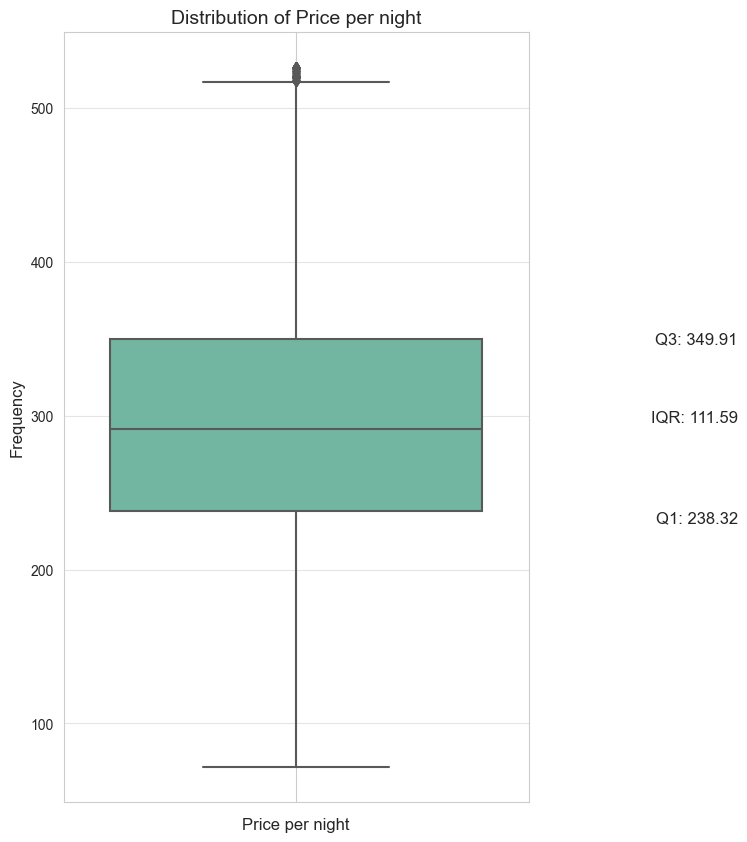

In [52]:
plt.figure(figsize=(6, 10))
sns.set_style('whitegrid')

sns.boxplot(y='price_per_night', data=booking_df, palette='Set2')
plt.grid(True)

plt.title('Distribution of Price per night', fontsize=14)
plt.xlabel('Price per night', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.grid(axis='y', alpha=0.5)

q1, q3 = booking_df['price_per_night'].quantile([0.25, 0.75])
iqr = q3 - q1
plt.text(0.95, q1, f'Q1: {q1:.2f}', fontsize=12, va='top', ha='right')
plt.text(0.95, q3, f'Q3: {q3:.2f}', fontsize=12, va='center', ha='right')
plt.text(0.95, q1 + 0.5*iqr, f'IQR: {iqr:.2f}', fontsize=12, va='bottom', ha='right')

plt.show()

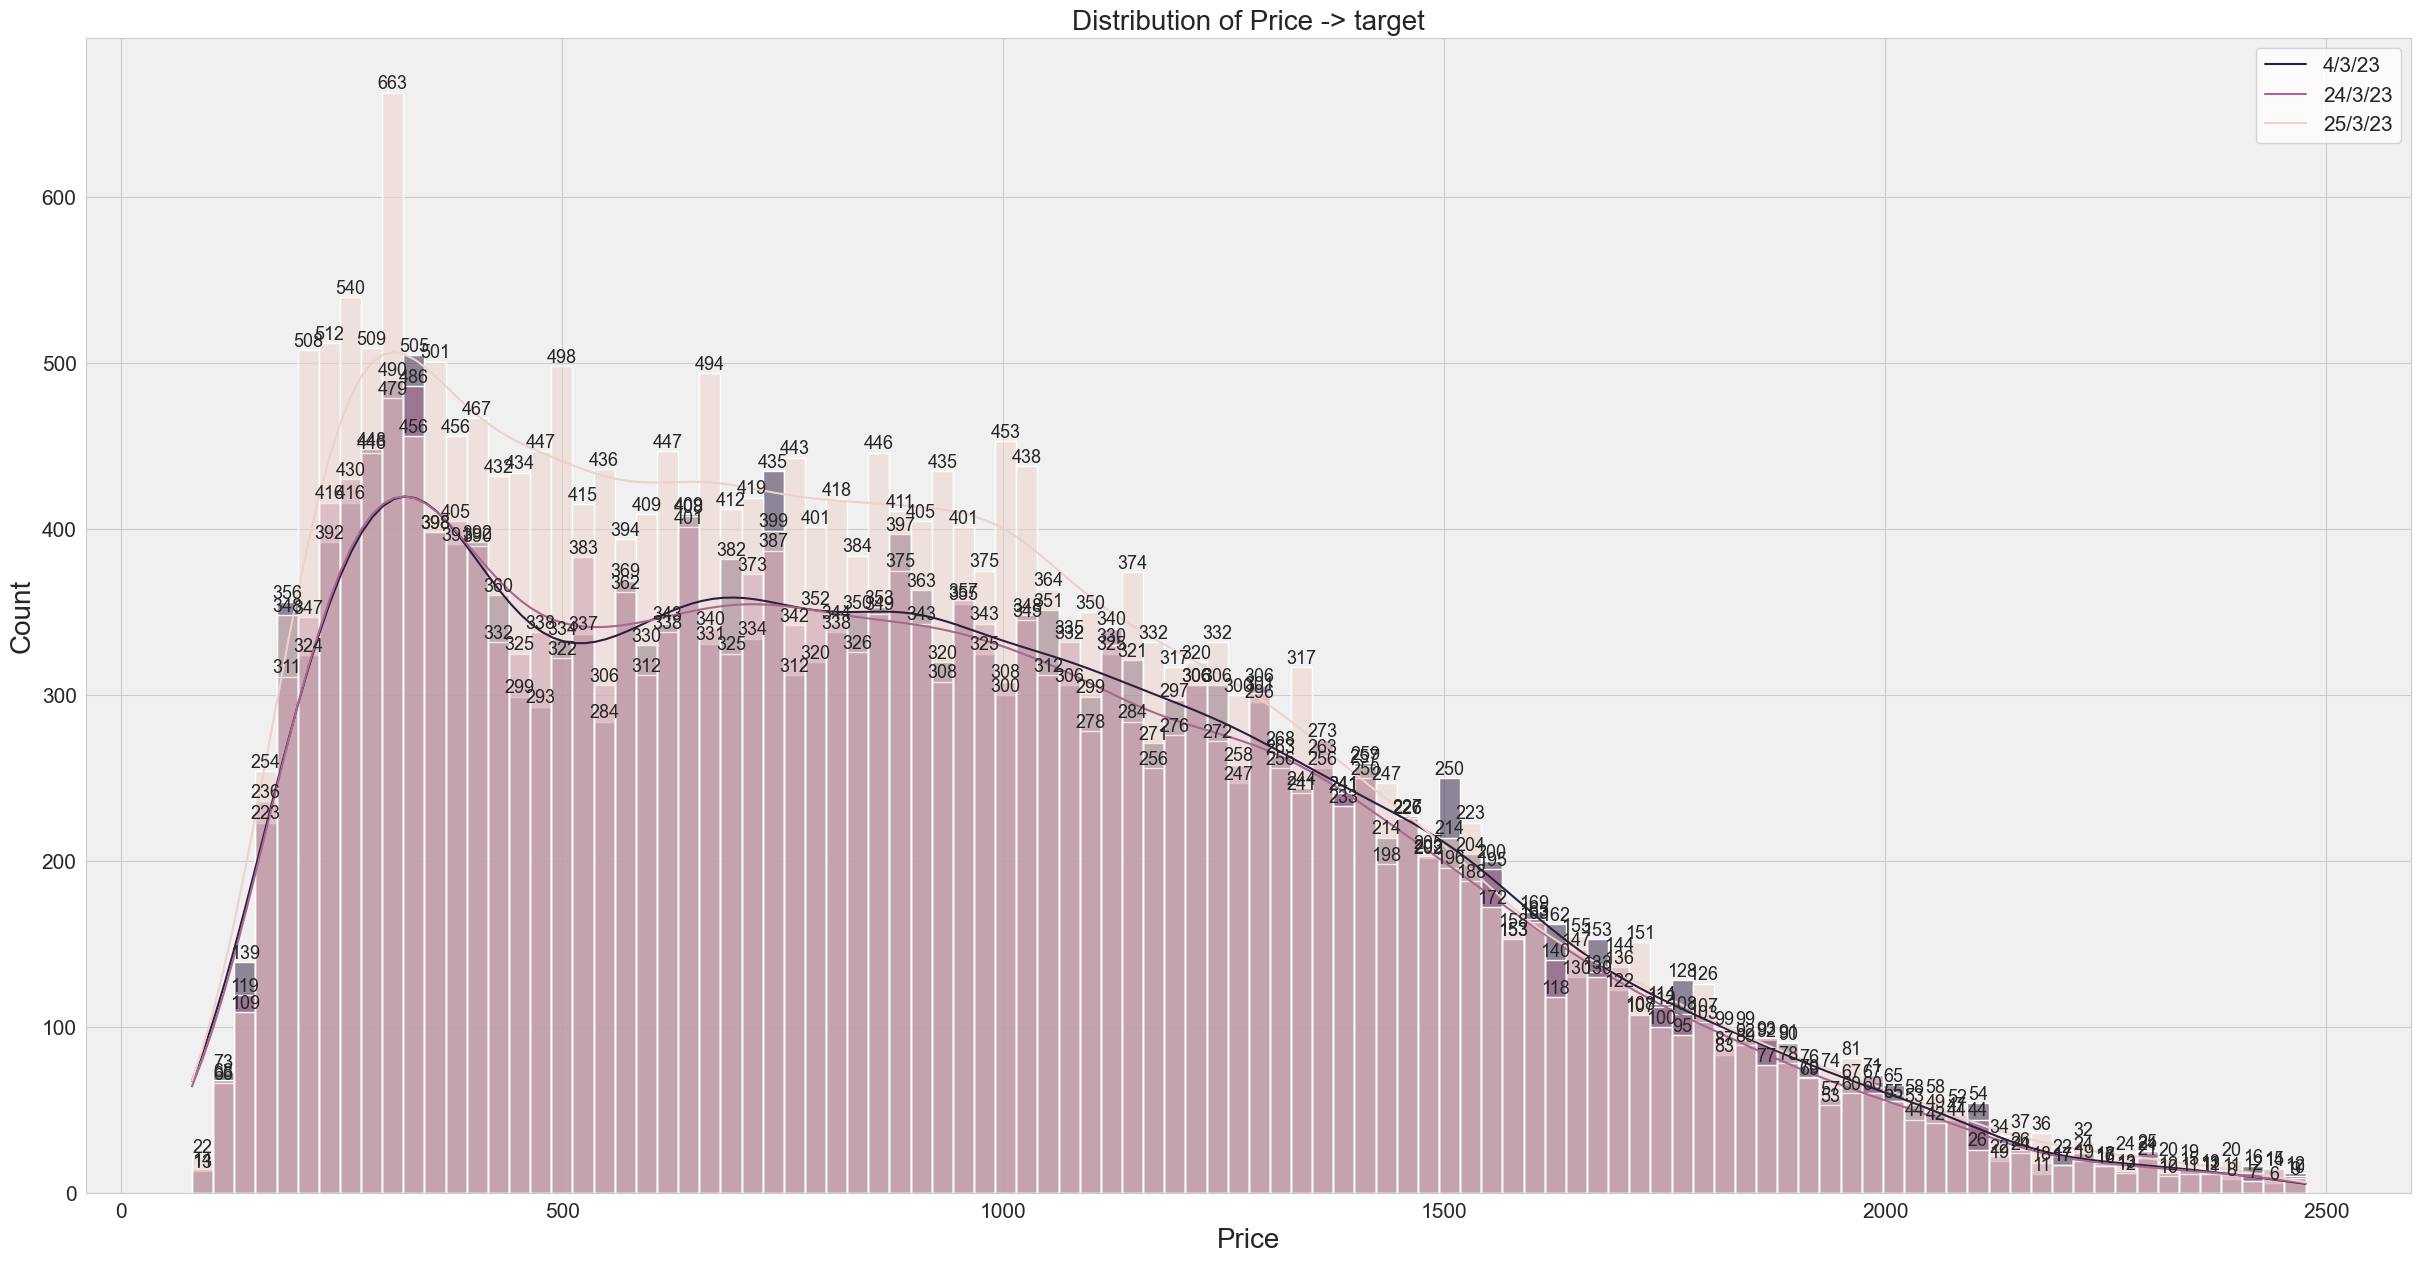

In [60]:
plt.figure(figsize=(30, 15))
sns.set_style('whitegrid')
ax = sns.histplot(x='price', data=booking_df,hue = 'sample_id', kde=True, bins=100, color='skyblue',alpha=0.5)

# rotate x-axis labels
plt.title('Distribution of Price -> target', fontsize=20)
plt.xlabel('Price', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.gca().set_axisbelow(True)
plt.gca().set_facecolor('#f0f0f0')
legend = ['4/3/23','24/3/23','25/3/23']
plt.legend(legend, fontsize=15)
for rect in ax.patches:
    x_value = rect.get_x() + rect.get_width() / 2
    y_value = rect.get_height()
    label = f'{y_value:.0f}'
    ax.text(x_value, y_value, label, ha='center', va='bottom', fontsize=13)

plt.show()

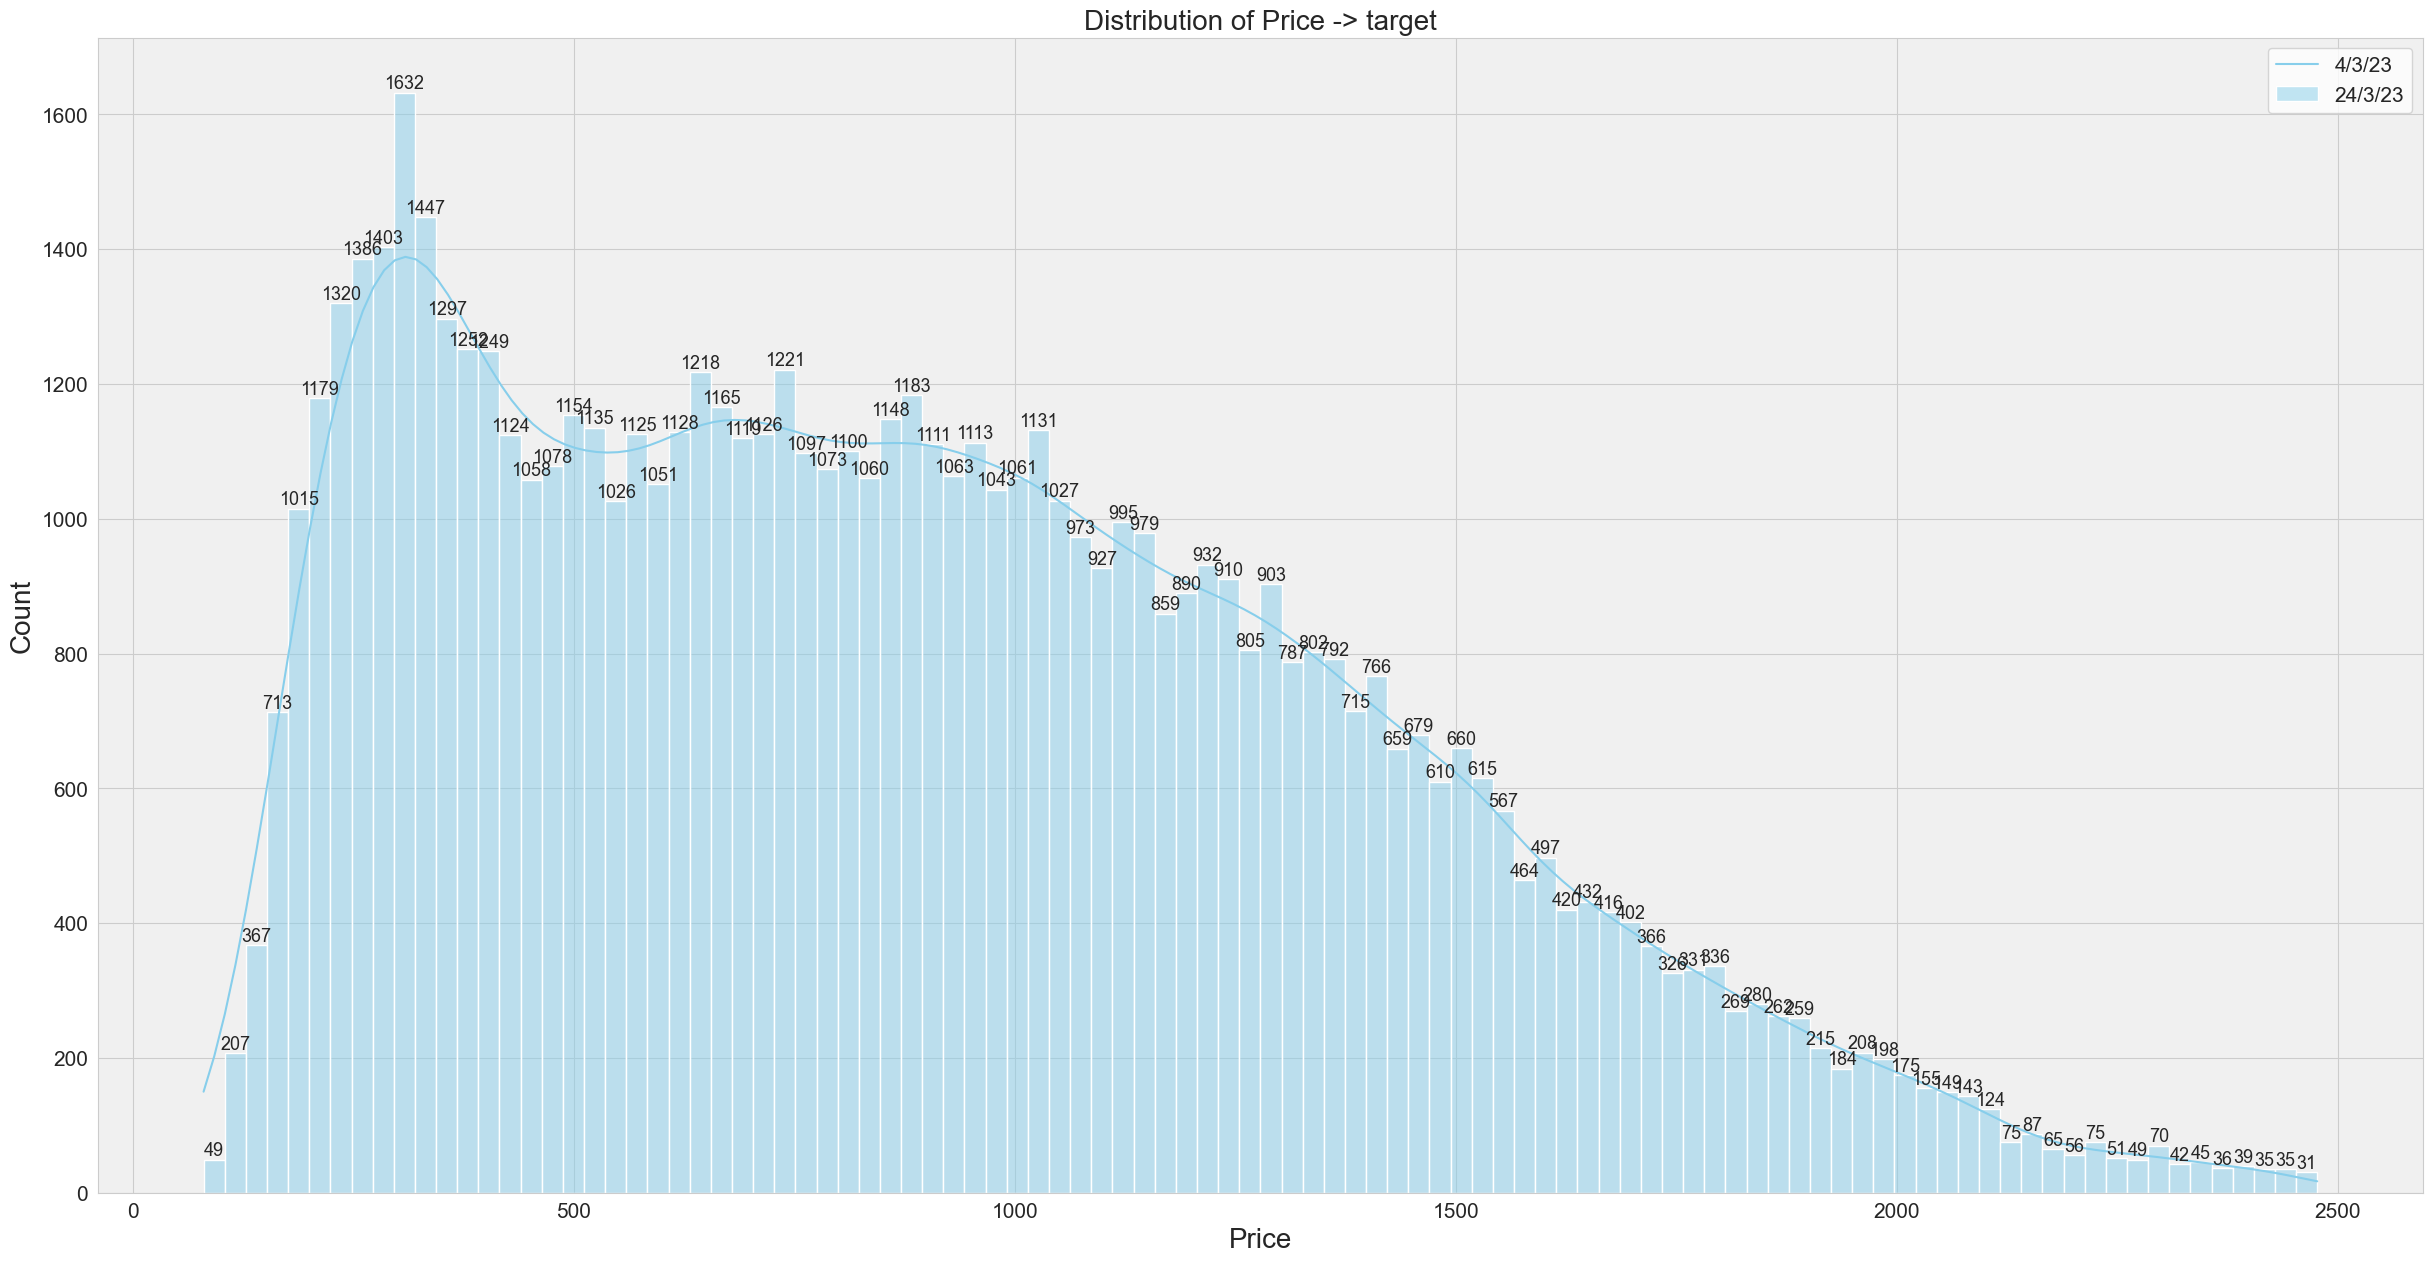

In [61]:
plt.figure(figsize=(30, 15))
sns.set_style('whitegrid')
ax = sns.histplot(x='price', data=booking_df, kde=True, bins=100, color='skyblue',alpha=0.5)

# rotate x-axis labels
plt.title('Distribution of Price -> target', fontsize=20)
plt.xlabel('Price', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.gca().set_axisbelow(True)
plt.gca().set_facecolor('#f0f0f0')
legend = ['4/3/23','24/3/23','25/3/23']
plt.legend(legend, fontsize=15)
for rect in ax.patches:
    x_value = rect.get_x() + rect.get_width() / 2
    y_value = rect.get_height()
    label = f'{y_value:.0f}'
    ax.text(x_value, y_value, label, ha='center', va='bottom', fontsize=13)

plt.show()

/var/folders/cr/sz5qnpp96w183bm2h622d9yc0000gn/T/ipykernel_44850/1682101841.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_booking_df = booking_df.corr()


<AxesSubplot: >

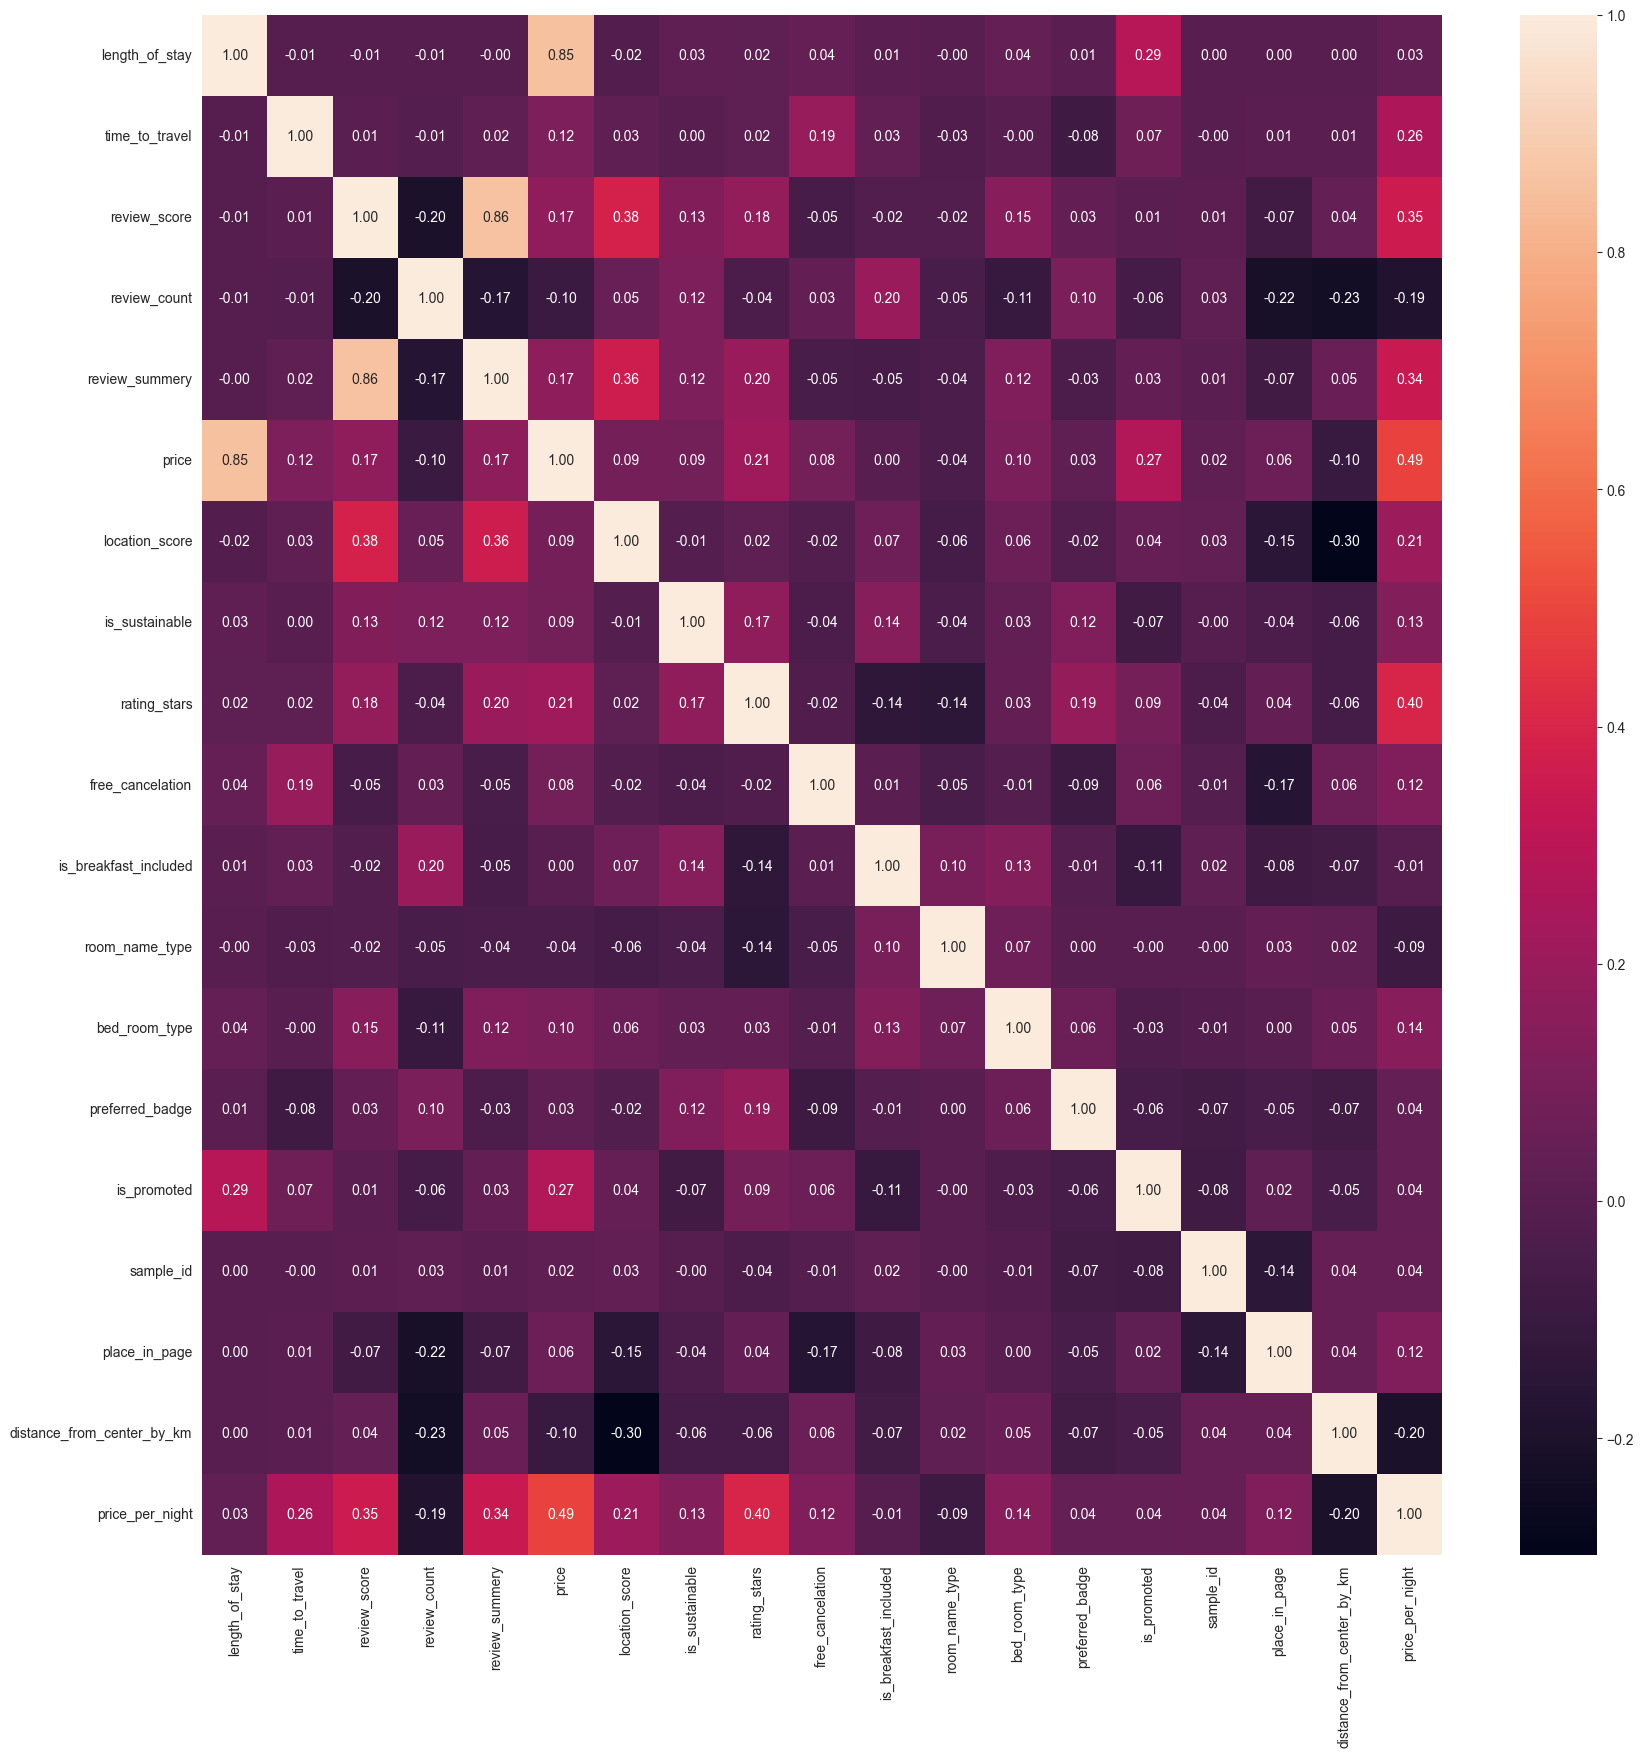

In [62]:
corr_booking_df = booking_df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_booking_df, annot=True, fmt='.2f')

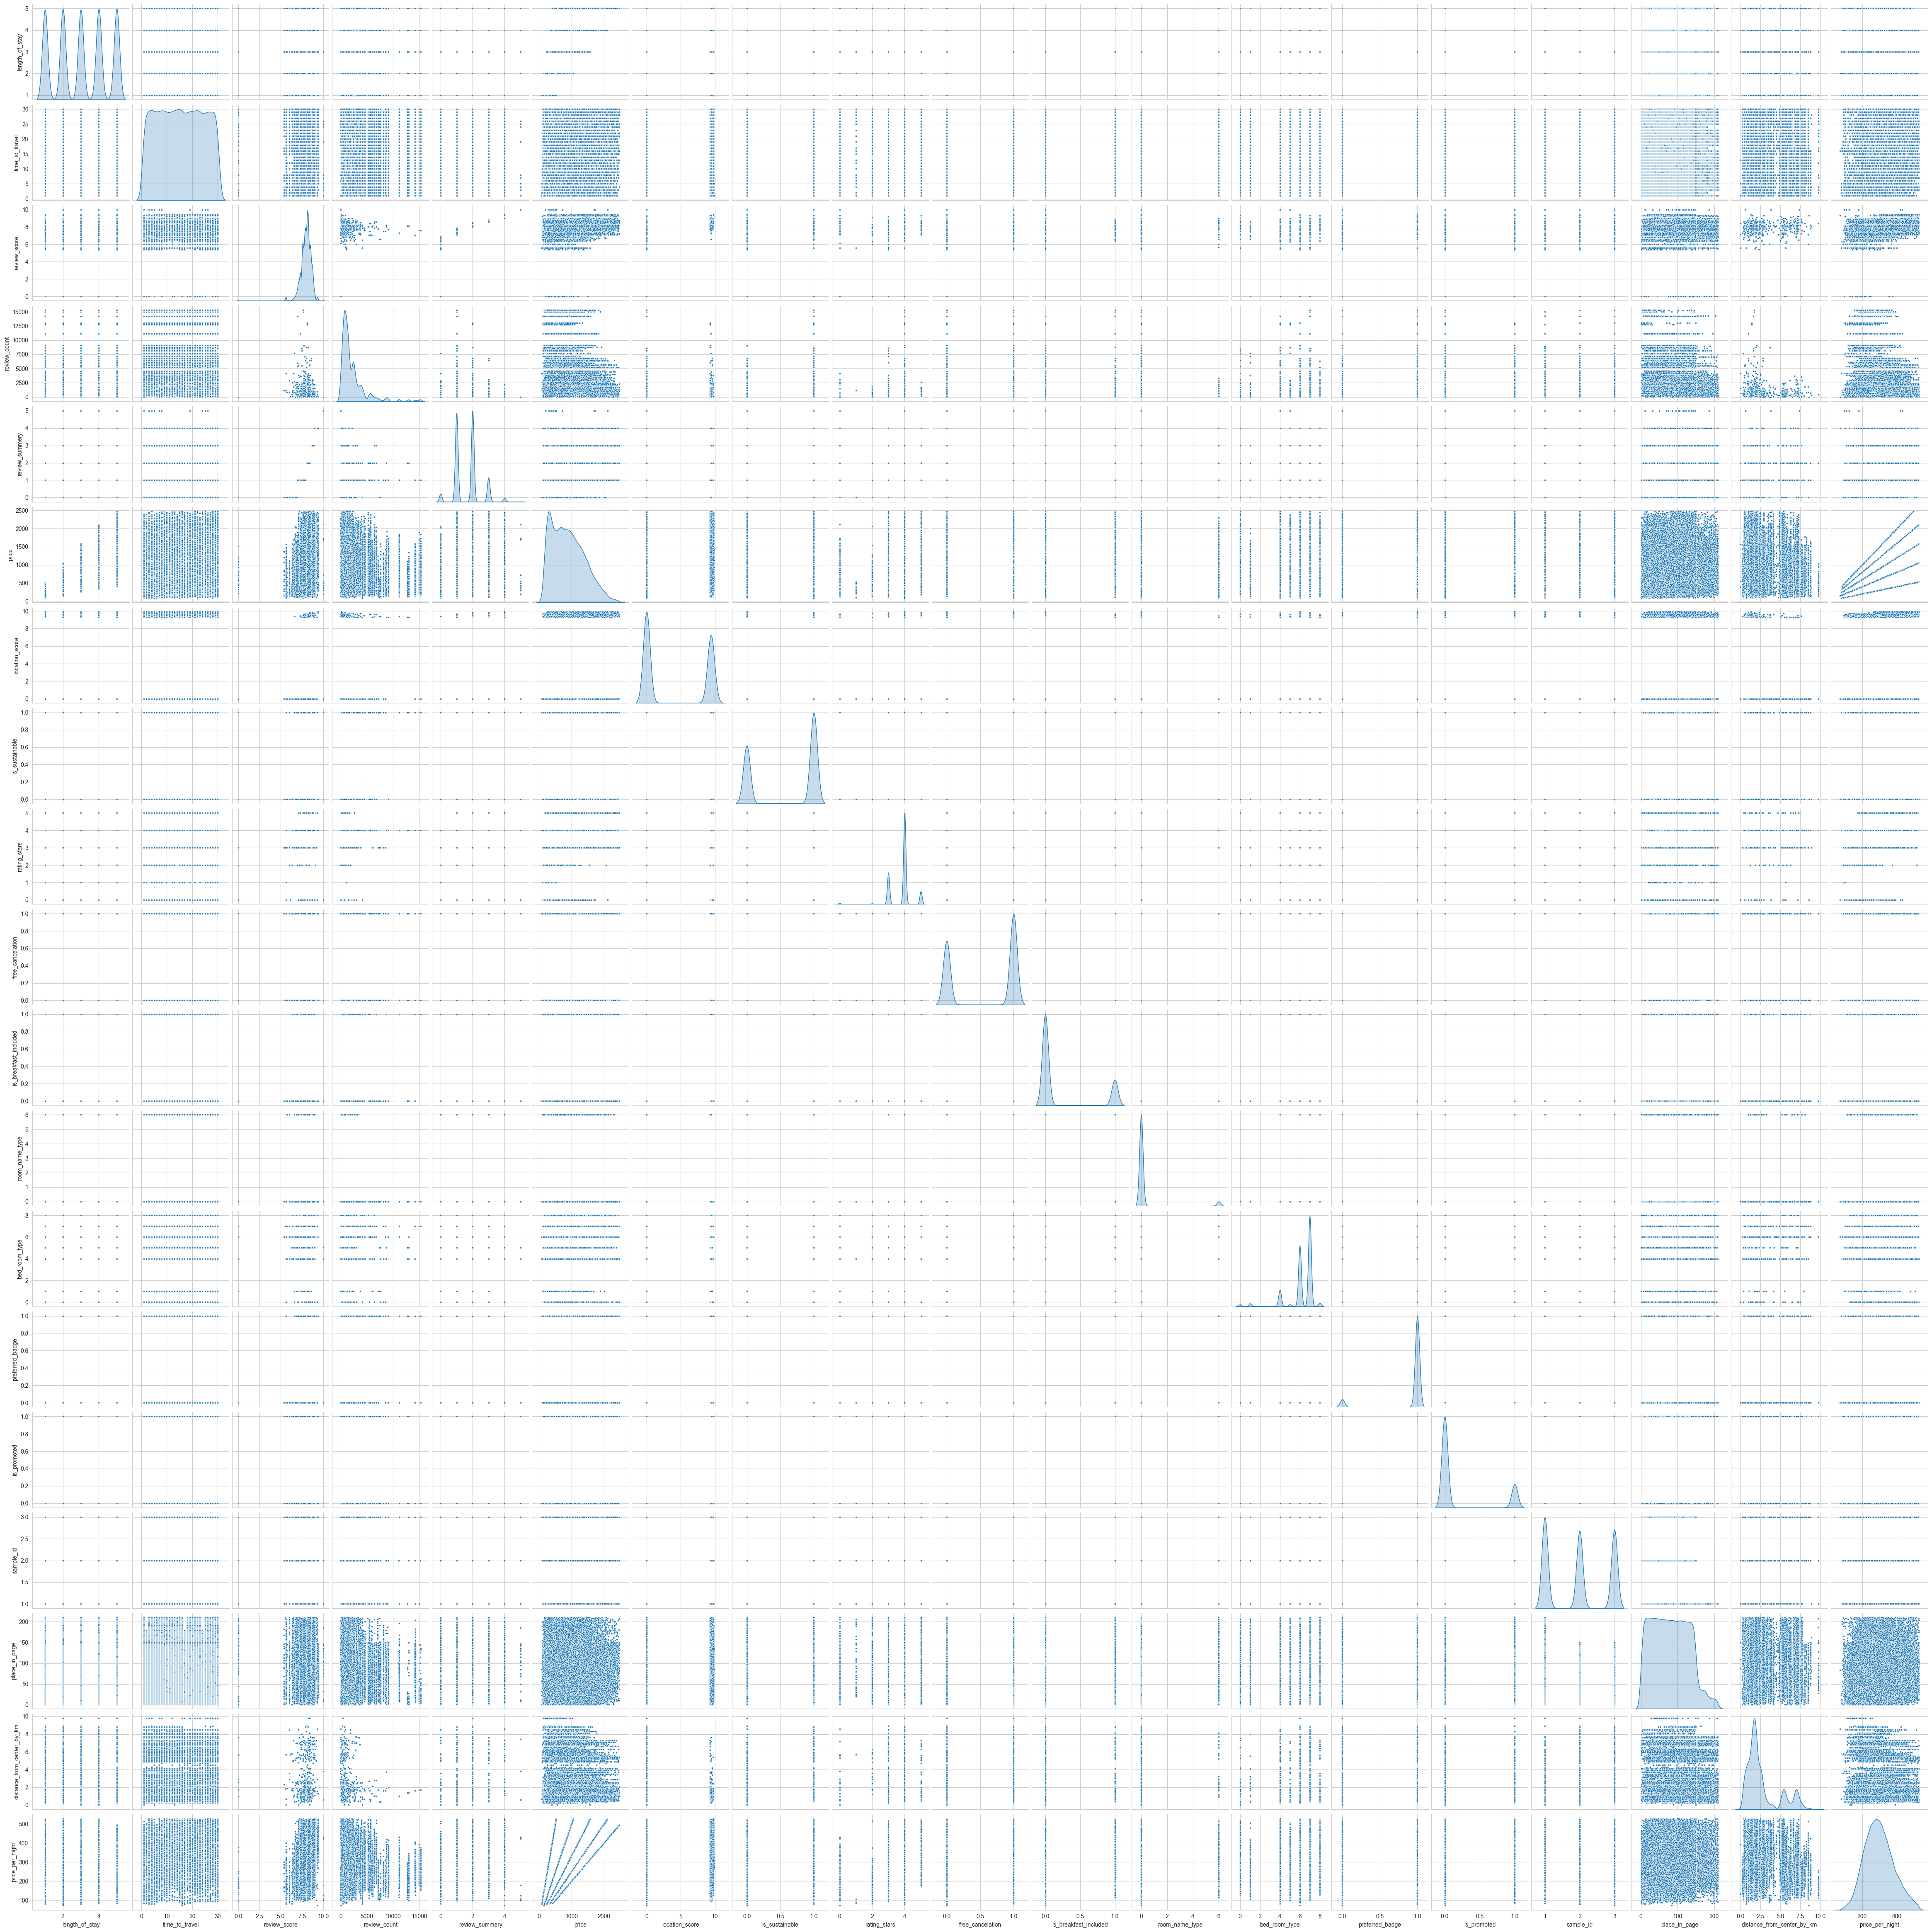

In [63]:
sns.set_style('whitegrid')
sns.pairplot(booking_df, markers='.', diag_kind='kde')
plt.show()

The graph in question indicates the presence of numerous variables that exhibit an ordinal order relationship. As such, the application of regression techniques holds promise in addressing the associated challenges. Furthermore, owing to the modest degree of correlation between the variables, a more refined approach that entails connecting variables with a more uniform meaning is likely to yield superior predictive outcomes in price prediction.

In [65]:
booking_df.drop('sample_id', axis=1, inplace=True)
booking_df.to_csv('booking_properties_cleaned_2.csv', index=False)

KeyError: "['sample_id'] not found in axis"